#**Statistical Analysis Of Financial Data - Project Part 2**
#AdaBoost.RT: a Boosting Algorithm for Regression Problems

##Group 3: Ashish Agarwal (170123011) and Bagel Satej Babanrao (170123013)



**Disclaimer**: *The content of this report and the product made is only meant for learning process as part of the course. This is not for use of making publication or making commercialisation without mentor’s consent. My contribution won’t demand any claim in future for further progress of Mentor’s development and innovation along the direction unless there is a special continuous involvement.*



We use the decision tree algorithm implemented in the first part of the project as a blackbox and implement AdaBoost.RT: a Boosting Algorithm for Regression Problems. 

##The Algorithm


1. Input    

* Sequence of $n$ examples $(x_1, y_1), (x_2, y_2),..., (x_n, y_n)$ where $y \in R$.
* Weak learning algorithm _Weak Learner_ (Decision tree algorithm in our case)
* Integer **T** specifying number of iterations
* Threshold $\phi$ for demacrating correct and incorrect predictions for AdaBoost.RT    

2. Initialize

* Machine number or iteration $t = 1$
* Distribution $D_t(i) = 1 / m$ for all $i$

3. Iterate While $t \leq T$

* Call _Weak Learner_, providing it with distribution $D_t$
* Build the regressor model: $f_t(x) \xrightarrow{} y$
* Calculate the error rate of $f_t(x)$: 
$\epsilon_t = \sum_{i: \left| \frac{f_t(x_i) - y_i}{y_i}\right| > \phi} D_t(i)$

* Set $\beta_t = \epsilon_t / (1 - \epsilon_t)$
* Update distribution $D_t$ as
$D_{t+1}(i) = \frac{D_t(i)}{Z_t} \times \begin{cases} \beta_t & \text{if} \enspace \left| \frac{f_t(x_i) - y_i}{y_i}\right| \leq \phi \\ 1 & \text{otherwise} \end{cases}$ where $Z_t$ is a normalization factor chosen such that $D_{t+1}$ will be a distribution.
* Set $t = t + 1$

4. Output the final hypothesis:

* $f_{fin}(x) = \frac{\sum_t log(1 / \beta_t) f_t(x)}{ \sum_t log(1 / \beta_t)}$







##Main Idea
* $\epsilon_t$ is computed using the notion of a pre-set threshold $\phi$, which is used to demarcate prediction error as correct or incorrect. If the absolute relative error (ARE) for any particular example is greater than $\phi$, the predicted value for this example is considered to be incorrect, otherwise it is correct. The numbers of correct and incorrect predictions are counted to calculate $\epsilon_t$.
* To compute the distribution for the next machine, we
multiply the weight of each example by $\beta_t$ if the previous machine classifies or predicts this example correctly (this reduces lhe weight of the example), and otherwise the weight remains unchanged. Thus it seems that the regression problem in AdaBoost.RT is projected into the binary classification problems while updating the weights of the examples. 

###References
Link: https://ieeexplore.ieee.org/document/1380102

##The Decision Tree Algorithm

In [1]:
import numpy as np
import sklearn.metrics as metrics

class TreeNode:
    def __init__(self):
        self.predicted_value = None
        self.decision_feature = None
        self.decision_value = None
        self.left_node = None
        self.right_node = None

class DecisionTree:

    def __init__(self):
        self.root_node = None
        self.min_coef_of_var = None
        self.reductions = None

    def fit(self, X, Y, min_coef_of_var = 0, pruning_factor = 0):
        self.min_coef_of_var = min_coef_of_var
        self.root_node = self.build(X, Y)
        self.prune_decision_tree(X, Y, self.root_node, pruning_factor)

        self.reductions = np.zeros(len(X[0]))
        self.reductions = self.calculate_reductions(X, Y, self.root_node, self.reductions)

    def get_decision_value_for_feature(self, X, Y, decision_feature):
        
        Z = np.empty((0, 2), float)
        for i in range(len(Y)):
            Z = np.append(Z, [[X[i, decision_feature], Y[i]]], axis = 0)

        Z = np.sort(Z, axis = 0)

        left_cardinality = 0
        right_cardinality = 0
        left_sum = 0
        right_sum = 0
        left_sum_of_squares = 0
        right_sum_of_squares = 0

        for i in range(len(Z)):
            right_cardinality += 1
            right_sum += Z[i, 1]
            right_sum_of_squares += Z[i, 1] ** 2

        current_best_impurity = right_sum_of_squares
        current_best_decision_value = Z[0, 0] - 1

        for i in range(len(Z)):
            left_cardinality += 1
            left_sum += Z[i, 1]
            left_sum_of_squares += Z[i, 1] ** 2

            right_cardinality -= 1
            right_sum -= Z[i, 1]
            right_sum_of_squares -= Z[i, 1] ** 2

            impurity = left_sum_of_squares - left_sum * left_sum / left_cardinality
            if (right_cardinality != 0):
                impurity += right_sum_of_squares - right_sum * right_sum / right_cardinality
            
            if (impurity < current_best_impurity):
                current_best_impurity = impurity
                current_best_decision_value = Z[i, 0]

        return current_best_decision_value

    def get_impurity(self, X, Y, decision_feature, decision_value_for_feature):
        left_cardinality = 0
        right_cardinality = 0
        left_sum = 0
        right_sum = 0

        for i in range(len(Y)):
            if (X[i, decision_feature] <= decision_value_for_feature):
                left_cardinality += 1
                left_sum += Y[i]
            else:
                right_cardinality += 1
                right_sum += Y[i]

        if (left_cardinality != 0):
            left_mean = left_sum / left_cardinality
        else:
            left_mean = 0

        if (right_cardinality != 0):
            right_mean = right_sum / right_cardinality
        else:
            right_mean = 0

        impurity = 0
        for i in range(len(Y)):
            if (X[i, decision_feature] <= decision_value_for_feature):
                impurity += (Y[i] - left_mean) ** 2
            else:
                impurity += (Y[i] - right_mean) ** 2

        return impurity

    def divide_data(self, X, Y, decision_feature, decision_value):
        number_of_features = len(X[0])
        X_left = np.empty((0, number_of_features), float)
        X_right = np.empty((0, number_of_features), float)
        Y_left = np.empty(0, float)
        Y_right = np.empty(0, float)

        for i in range(len(X)):
            if (X[i, decision_feature] <= decision_value):
                X_left = np.append(X_left, [X[i]], axis = 0)
                Y_left = np.append(Y_left, [Y[i]], axis = 0)
            else:
                X_right = np.append(X_right, [X[i]], axis = 0)
                Y_right = np.append(Y_right, [Y[i]], axis = 0)

        return X_left, Y_left, X_right, Y_right

    def build(self, X, Y):
        if (len(X) == 0):
            return

        root_node = TreeNode()
        node_mean = np.mean(Y)
        root_node.predicted_value = node_mean
        node_deviation = np.std(Y)

        # Do not split
        if (node_deviation / node_mean < self.min_coef_of_var):
            root_node.decision_value = 0
            root_node.decision_feature = 0
            return

        if (np.amin(Y) == np.amax(Y)):
            root_node.decision_value = 0
            root_node.decision_feature = 0
            return root_node

        number_of_features = len(X[0])
        current_best_feature = -1
        current_best_decision_value = -1
        current_best_impurity = -1

        for i in range(number_of_features):
            decision_value_for_feature = self.get_decision_value_for_feature(X, Y, i)
            impurity_of_decision_value = self.get_impurity(X, Y, i, decision_value_for_feature)

            if (current_best_feature == -1 or impurity_of_decision_value < current_best_impurity):
                current_best_feature = i
                current_best_decision_value = decision_value_for_feature
                current_best_impurity = impurity_of_decision_value

        root_node.decision_feature = current_best_feature
        root_node.decision_value = current_best_decision_value

        X_left, Y_left, X_right, Y_right = self.divide_data(X, Y, root_node.decision_feature, root_node.decision_value)

        if (len(Y_left) == 0 or len(Y_right) == 0):
            return root_node

        root_node.left_node = self.build(X_left, Y_left)
        root_node.right_node = self.build(X_right, Y_right)
        return root_node

    def prune_decision_tree(self, X, Y, root_node, pruning_factor):
        if (root_node == None):
          return 0

        X_left, Y_left, X_right, Y_right = self.divide_data(X, Y, root_node.decision_feature, root_node.decision_value)
        left_tree_size = self.prune_decision_tree(X_left, Y_left, root_node.left_node, pruning_factor)
        right_tree_size = self.prune_decision_tree(X_right, Y_right, root_node.right_node, pruning_factor)
        tree_size = 1 + left_tree_size + right_tree_size

        impurity = 0
        for y in Y:
            impurity += (y - root_node.predicted_value) ** 2

        divided_impurity = self.get_impurity(X, Y, root_node.decision_feature, root_node.decision_value)

        pruning_value = impurity / len(Y) - divided_impurity / len(Y) - pruning_factor * tree_size

        if (pruning_value < 0):
            root_node.left_node = None
            root_node.right_node = None
            return 1
        else:
            return tree_size
    
    def calculate_reductions(self, X, Y, root_node, reductions):
        if (root_node == None):
            return reductions

        impurity = 0
        for y in Y:
            impurity += (y - root_node.predicted_value) ** 2

        for i in range(len(X[0])):
            decision_value_for_feature = self.get_decision_value_for_feature(X, Y, i)
            impurity_of_decision_value = self.get_impurity(X, Y, i, decision_value_for_feature)

            reductions[i] += impurity - impurity_of_decision_value
        
        X_left, Y_left, X_right, Y_right = self.divide_data(X, Y, root_node.decision_feature, root_node.decision_value)
        reductions = self.calculate_reductions(X_left, Y_left, root_node.left_node, reductions)
        reductions = self.calculate_reductions(X_right, Y_right, root_node.right_node, reductions)

        return reductions
    
    def get_reductions(self):
        return self.reductions

    def predict_single(self, X):
        current_node = self.root_node
        while (True):
            if (X[current_node.decision_feature] <= current_node.decision_value):
                if (current_node.left_node != None):
                    current_node = current_node.left_node
                else:
                    return current_node.predicted_value
            else:
                if (current_node.right_node != None):
                    current_node = current_node.right_node
                else:
                    return current_node.predicted_value

    def predict(self, X):
        Y = np.empty(0, float)
        for x in X:
            Y = np.append(Y, [self.predict_single(x)], axis = 0)

        return Y

## AdaBoostRT

In [2]:
class AdaBoostRT:

    def __init__(self):

        self.trees = []
        self.beta = []
        self.number_of_iterations = None

    def fit(self, X, y, threshold_phi = 0.3, number_of_iterations = 20, min_coef_of_var = 0.025, pruning_factor = 0.1):
        
        self.number_of_iterations = number_of_iterations
        N = len(X)
        D = [1 / N] * N

        for t in range(number_of_iterations):
            ids = self.find_ids_from_distribution(D)
            X_new, y_new = self.find_new_X_y(X, y, ids)

            new_tree = DecisionTree()
            new_tree.fit(X_new, y_new, min_coef_of_var, pruning_factor)
            y_pred = new_tree.predict(X)
            self.trees.append(new_tree)

            eps_t = self.cal_error_rate(D, y, y_pred, threshold_phi)
            self.beta.append(eps_t / (1 - eps_t))

            D = self.improved_distribution(D, y, y_pred, threshold_phi, self.beta[t])

    def predict_single(self, X):

        weighted_y = 0
        total_weight = 0
        
        for i in range(self.number_of_iterations):
            weighted_y += np.log(1 / self.beta[i]) * self.trees[i].predict_single(X)
            total_weight += np.log(1 / self.beta[i])
        
        return weighted_y / total_weight

    def predict(self, X):
        
        y = np.empty(0, float)
        for x in X:
            y = np.append(y, [self.predict_single(x)], axis = 0)

        return y

    def improved_distribution(self, D, y, y_pred, threshold_phi, beta):

        for i in range(len(D)):
            if (abs((y_pred[i] - y[i]) / y[i]) <= threshold_phi):
                D[i] *= beta
        Z = sum(D)

        for i in range(len(D)):
            D[i] /= Z
        
        return D

    def cal_error_rate(self, D, y, y_pred, threshold_phi):
        
        eps_t = 0
        for i in range(len(y)):
            if (abs((y_pred[i] - y[i]) / y[i]) > threshold_phi):
                eps_t += D[i]

        return eps_t

    def find_new_X_y(self, X, y, ids): # samples new X, y

        number_of_features = len(X[0])
        X_new = np.empty((0, number_of_features), float)
        y_new = np.empty(0, float)

        for i in ids:
            X_new = np.append(X_new, [X[i]], axis = 0)
            y_new = np.append(y_new, [y[i]], axis = 0)

        return X_new, y_new

    def find_ids_from_distribution(self, D): # genarates N discrete random variable from the given distribution

        N = len(D)
        cdf = [D[0]]
        ids = []

        for i in range(N - 1):
            cdf.append(cdf[i] + D[i+1])

        r = np.random.uniform(0, 1, N)
        for i in range(N):
            ids.append(self.find_id_from_cdf(r[i], cdf))
        
        return ids

    def find_id_from_cdf(self, r, cdf): # genarates one discrete random variable from the given CDF using binary search

        N = len(cdf)

        low = 0
        high = N - 1

        while (low != high):
            mid = (low + high + 1) // 2
            if (cdf[mid] < r):
                low = mid
            else:
                high = mid - 1
        return low

We start by testing our algorithm on boston housing dataset from sklearn library.

In [3]:
from sklearn.datasets import load_boston
data = load_boston(return_X_y=False)
X = data.data
y = data.target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
print(X_train.shape)

(404, 13)


In [4]:
import time
start_time = time.time()
decision_tree = DecisionTree()
decision_tree.fit(X_train, y_train, min_coef_of_var = 0.025, pruning_factor = 0)
y_pred = decision_tree.predict(X_test)
print('R2 Score: ', metrics.r2_score(y_test, y_pred))
print('Time taken to run: ', time.time() - start_time)

R2 Score:  0.7114290465682265
Time taken to run:  1.3140950202941895


We can see that _weak learner_ algorithm (Decision Tree) gives an accuracy of (~71%).

We run our algorithm mutiple times with different parameters.

In [5]:
start_time = time.time()
adaBoostRT = AdaBoostRT()
adaBoostRT.fit(X_train, y_train, threshold_phi = 0.5, number_of_iterations = 20, min_coef_of_var = 0.025, pruning_factor = 0)
y_pred = adaBoostRT.predict(X_test)
print('R2 Score: ', metrics.r2_score(y_test, y_pred))
print('Time taken to run: ', time.time() - start_time)

R2 Score:  0.8413794046211733
Time taken to run:  22.40511441230774


In [6]:
start_time = time.time()
adaBoostRT = AdaBoostRT()
adaBoostRT.fit(X_train, y_train, threshold_phi = 0.5, number_of_iterations = 40, min_coef_of_var = 0.025, pruning_factor = 0)
y_pred = adaBoostRT.predict(X_test)
print('R2 Score: ', metrics.r2_score(y_test, y_pred))
print('Time taken to run: ', time.time() - start_time)

R2 Score:  0.8468563231959942
Time taken to run:  42.90940046310425


In [7]:
start_time = time.time()
adaBoostRT = AdaBoostRT()
adaBoostRT.fit(X_train, y_train, threshold_phi = 0.3, number_of_iterations = 20, min_coef_of_var = 0.025, pruning_factor = 0)
y_pred = adaBoostRT.predict(X_test)
print('R2 Score: ', metrics.r2_score(y_test, y_pred))
print('Time taken to run: ', time.time() - start_time)

R2 Score:  0.7596779791791901
Time taken to run:  21.60567307472229


In [8]:
start_time = time.time()
adaBoostRT = AdaBoostRT()
adaBoostRT.fit(X_train, y_train, threshold_phi = 0.3, number_of_iterations = 40, min_coef_of_var = 0.025, pruning_factor = 0)
y_pred = adaBoostRT.predict(X_test)
print('R2 Score: ', metrics.r2_score(y_test, y_pred))
print('Time taken to run: ', time.time() - start_time)

R2 Score:  0.836327016256547
Time taken to run:  40.33699655532837


AdaBoost.RT improves the accuract of _weak learner_ from (\~71%) to \(~84%), which is a huge improvemnt.

A plot of predicted value v/s actual value is present below.

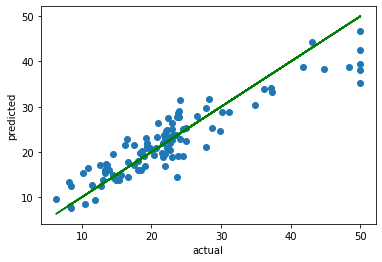

In [9]:
import matplotlib.pyplot as plt
plt.plot(y_test, y_test, color = "green")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test, y_pred)
plt.show()

We also test our algorithm on california housing dataset from sklearn library.

In [10]:
N = 1000
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(return_X_y=False)
X = data.data[:N]
y = data.target[:N]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape)

(800, 8)


In [11]:
start_time = time.time()
decision_tree = DecisionTree()
decision_tree.fit(X_train, y_train, min_coef_of_var = 0.025, pruning_factor = 0)
y_pred = decision_tree.predict(X_test)
print('R2 Score: ', metrics.r2_score(y_test, y_pred))
print('Time taken to run: ', time.time() - start_time)

R2 Score:  0.6117023198500051
Time taken to run:  1.9802436828613281


We can see that _weak learner_ algorithm (Decision Tree) gives an accuracy of (~61%).

We run our algorithm mutiple times with different parameters.

In [12]:
start_time = time.time()
adaBoostRT = AdaBoostRT()
adaBoostRT.fit(X_train, y_train, threshold_phi = 0.3, number_of_iterations = 80, min_coef_of_var = 0.025, pruning_factor = 0)
y_pred = adaBoostRT.predict(X_test)
print('R2 Score: ', metrics.r2_score(y_test, y_pred))
print('Time taken to run: ', time.time() - start_time)

R2 Score:  0.694723696773404
Time taken to run:  125.77881836891174


In [13]:
start_time = time.time()
adaBoostRT = AdaBoostRT()
adaBoostRT.fit(X_train, y_train, threshold_phi = 0.3, number_of_iterations = 40, min_coef_of_var = 0.025, pruning_factor = 0)
y_pred = adaBoostRT.predict(X_test)
print('R2 Score: ', metrics.r2_score(y_test, y_pred))
print('Time taken to run: ', time.time() - start_time)

R2 Score:  0.7120328246199294
Time taken to run:  59.74291777610779


In [14]:
start_time = time.time()
adaBoostRT = AdaBoostRT()
adaBoostRT.fit(X_train, y_train, threshold_phi = 0.5, number_of_iterations = 80, min_coef_of_var = 0.025, pruning_factor = 0)
y_pred = adaBoostRT.predict(X_test)
print('R2 Score: ', metrics.r2_score(y_test, y_pred))
print('Time taken to run: ', time.time() - start_time)

R2 Score:  0.6893012857644062
Time taken to run:  110.9093279838562


In [15]:
start_time = time.time()
adaBoostRT = AdaBoostRT()
adaBoostRT.fit(X_train, y_train, threshold_phi = 0.5, number_of_iterations = 40, min_coef_of_var = 0.025, pruning_factor = 0)
y_pred = adaBoostRT.predict(X_test)
print('R2 Score: ', metrics.r2_score(y_test, y_pred))
print('Time taken to run: ', time.time() - start_time)

R2 Score:  0.6911634507664597
Time taken to run:  52.760990381240845


AdaBoost.RT improves the accuract of _weak learner_ from (\~61%) to \(~71%), which is a huge improvement.

A plot of predicted value v/s actual value is present below.

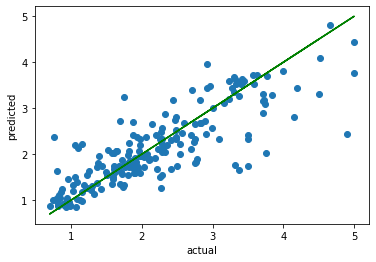

In [16]:
import matplotlib.pyplot as plt
plt.plot(y_test, y_test, color = "green")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test, y_pred)
plt.show()